In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
%%time

dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

data = pd.read_csv("resources/train.csv", dtype=dtypes)


CPU times: total: 1min 2s
Wall time: 1min 33s


In [32]:
data.info()
print("Train size:", data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 3.1 GB
Train size: (101230332, 10)


In [33]:
train = data.copy()

In [34]:
%%time

questions = pd.read_csv("resources/questions.csv", dtype=dtypes)

print("Train size:", questions.shape)

Train size: (13523, 5)
CPU times: total: 0 ns
Wall time: 12 ms


In [35]:
%%time

lectures = pd.read_csv("resources/lectures.csv", dtype=dtypes)

print("Train size:", questions.shape)

Train size: (13523, 5)
CPU times: total: 0 ns
Wall time: 3 ms


---

1. Сколько человек прошло тест (+ в разрезе курсов)
2. Рейтинг по пользователям (топ по правильным, топ по плохим, среднее время прохождения (+ топы по времени))
3. Топ сложных вопросов (больше всего неправильных ответов)
4. Корреляция правильных ответов и присутствия на лекции

### **Описание таблицы Метрики пользователей**

`timestamp` - не понял

`content_id` - ссылка на вопрос (`questions.question_id`) или лекцию (`lectures.lecture_id`)

`content_type_id` - тип задачи; `0` - вопрос, `1` - лекция

`task_container_id` - группировка вопросов (пачка вопрос на которые надо ответить прежде чем увидишь объяснение)

`user_answer` - `-1` у лекций, в остальном любое значение

`answered_correctly` - `-1` у лекций; `0` - ошибка, `1` - правильно

In [36]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
101230327,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


---

### **Описание таблицы Вопросы**

`question_id` - ссылка на `train.content_id` if `train.content_type_id == 0` (вопрос)

`bundle_id` - группировка вопросов в пачку

`correct_answer` - ответ на вопрос

`part` - раздел теста

`tags` - кластеризация вопросов

In [37]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


---

### **Описание таблицы Лекции**

`lecture_id` - ссылка на `train.content_id` if `train.content_type_id == 1` (лекция)

`tag` - для кластеризации

`part` - раздел теста

`type_of` - краткое описание основной цели лекции

In [38]:
lectures

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
...,...,...,...,...
413,32535,8,5,solving question
414,32570,113,3,solving question
415,32604,24,6,concept
416,32625,142,2,concept


---
# Анализ

In [58]:
train_questions = train[train.content_type_id == 0]
train_lectures = train[train.content_type_id == 1]

In [60]:
wrong = train_questions[train_questions.answered_correctly == 0]
users_id_with_wrong = wrong.user_id.unique()

In [62]:
correct = train_questions[train_questions.answered_correctly == 1]
users_id_with_correct = correct.user_id.unique()

### Кол-во пользоваталетей проходивших тестирование

In [39]:
train['user_id'].nunique()

393656

### Распределение пользователей по правильным ответам

In [161]:
''' Распределение пользователей по кол-ву решенных задач '''
correct_value_counts = correct.user_id.value_counts()
correct_value_counts

user_id
2139561972    14300
1615528747    13678
338684437     13416
1842816145    13086
1047202059    13034
              ...  
856608043         1
856589478         1
23235753          1
1663437695        1
870627731         1
Name: count, Length: 393470, dtype: int64

In [175]:
correct_value_counts_df = correct_value_counts.to_frame().reset_index()
correct_value_counts_df = correct_value_counts_df.rename(columns={'count': 'value'})
correct_value_counts_df

,user_id,value
0,2139561972,14300
1,1615528747,13678
2,338684437,13416
3,1842816145,13086
4,1047202059,13034
...,...,...
393465,856608043,1
393466,856589478,1
393467,23235753,1
393468,1663437695,1


In [182]:
correct_distribution = correct_value_counts_df['value'].value_counts().sort_index()
correct_distribution

value
1         733
2        1849
3        3756
4        6472
5        8878
         ... 
13034       1
13086       1
13416       1
13678       1
14300       1
Name: count, Length: 4750, dtype: int64

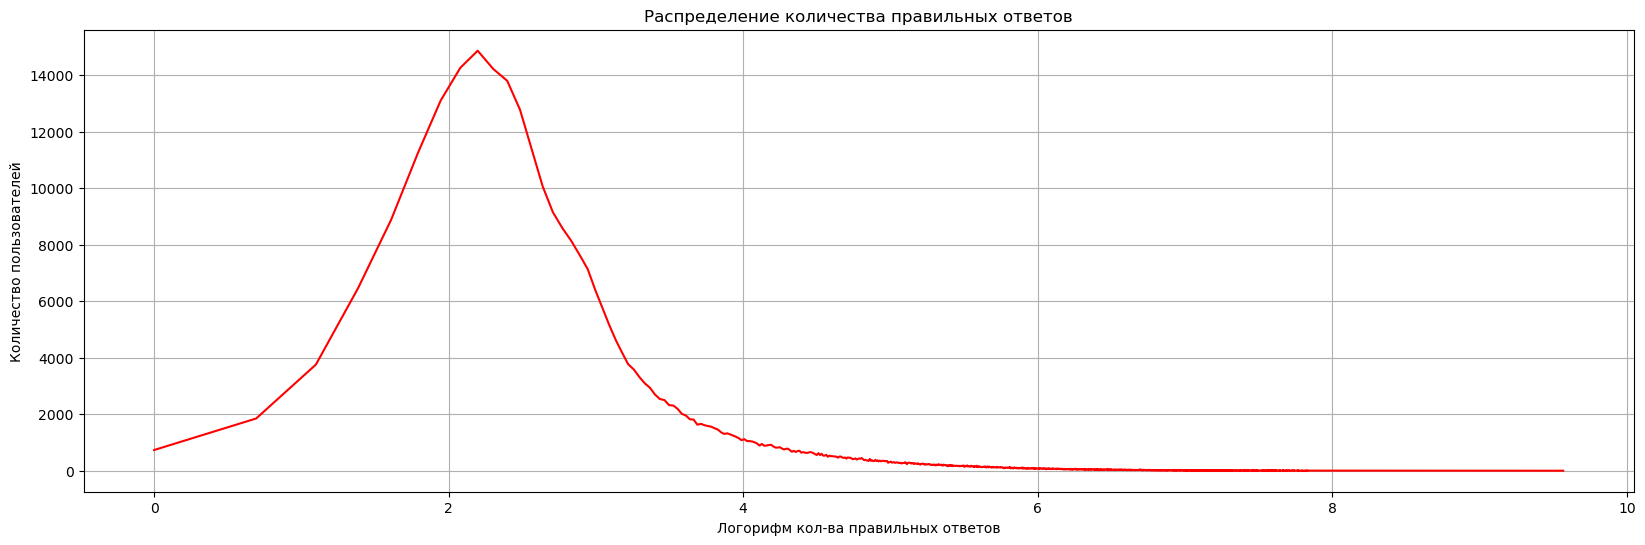

In [183]:
plt.figure(figsize=(20, 6))  
plt.plot(np.log(correct_distribution.index), correct_distribution.values, 'r')  
plt.title('Распределение количества правильных ответов')  
plt.xlabel('Логорифм кол-ва правильных ответов')  
plt.ylabel('Количество пользователей')  
plt.grid()  
# plt.xticks(distribution.index)  # Устанавливаем метки по оси X  
plt.show()

### Распределение пользователей по неправильным ответам

In [180]:
''' Распределение пользователей по кол-ву неправильных ответов '''
wrong_value_counts = wrong.user_id.value_counts()
wrong_value_counts

user_id
177898308     8112
1565505837    8083
1509564249    8017
7171715       7974
314180295     7588
              ... 
531962949        1
1079688722       1
1079649798       1
647561029        1
1238649895       1
Name: count, Length: 393445, dtype: int64

In [181]:
wrong_value_counts_df = wrong_value_counts.to_frame().reset_index()
wrong_value_counts_df = wrong_value_counts_df.rename(columns={'count': 'value'})
wrong_value_counts_df

,user_id,value
0,177898308,8112
1,1565505837,8083
2,1509564249,8017
3,7171715,7974
4,314180295,7588
...,...,...
393440,531962949,1
393441,1079688722,1
393442,1079649798,1
393443,647561029,1


In [184]:
wrong_distribution = wrong_value_counts_df['value'].value_counts().sort_index()
wrong_distribution

value
1        518
2       1258
3       2669
4       4535
5       7026
        ... 
7588       1
7974       1
8017       1
8083       1
8112       1
Name: count, Length: 2700, dtype: int64

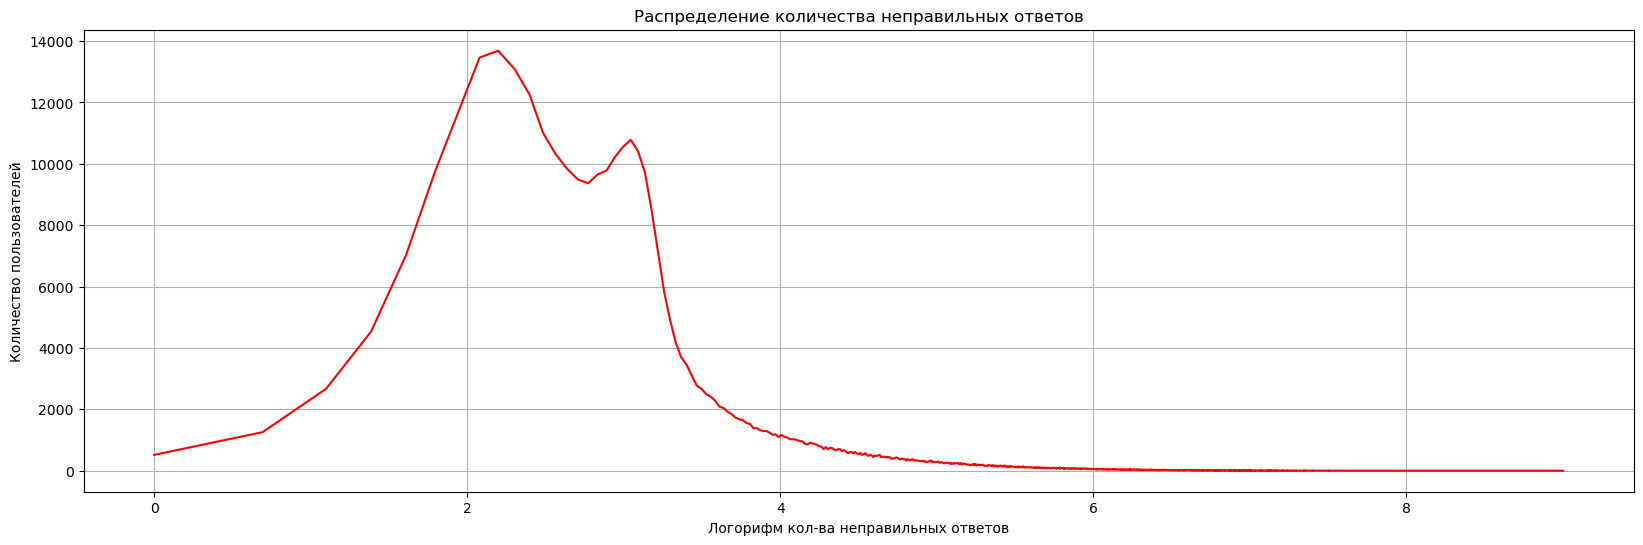

In [191]:
plt.figure(figsize=(20, 6))  
plt.plot(np.log(wrong_distribution.index), wrong_distribution.values, 'r')  
plt.title('Распределение количества неправильных ответов')  
plt.xlabel('Логорифм кол-ва неправильных ответов')  
plt.ylabel('Количество пользователей')  
plt.grid()  
# plt.xticks(np.log(wrong_distribution.index))  # Устанавливаем метки по оси X  
plt.show()

### Пользователи, у которых все правильные ответы или все неправильные

#### Все ответы правильные

In [68]:
# Все пользователи, которые не допустили ни одной ошибки
users_without_wrongs = train_questions[~train_questions.user_id.isin(users_id_with_wrong)]
users_without_wrongs

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
87415,87415,0,1880240,192,0,0,1,1,NaN,<NA>
2158464,2158464,0,45312560,7900,0,0,0,1,NaN,<NA>
2158465,2158465,20012,45312560,7876,0,1,3,1,15000.0,False
2158466,2158466,45505,45312560,175,0,2,2,1,17000.0,False
2158467,2158467,64031,45312560,1278,0,3,3,1,22000.0,False
...,...,...,...,...,...,...,...,...,...,...
100202912,100202912,2958094,2126774754,2946,0,6,3,1,42667.0,False
100202913,100202913,2958094,2126774754,2948,0,6,0,1,42667.0,False
100202914,100202914,2958094,2126774754,2947,0,6,1,1,42667.0,False
100388645,100388645,0,2131395801,5269,0,0,2,1,NaN,<NA>


In [149]:
''' Кол-во пользователей только с правильными ответами '''
users_without_wrongs.user_id.nunique()

211

In [82]:
''' Распределение пользователей по кол-ву решенных задач '''
users_without_wrongs_value_counts = users_without_wrongs.user_id.value_counts()
users_without_wrongs_value_counts

user_id
48102728      41
1913246299    40
173568036     40
2086209271    40
608140302     35
              ..
1801712607     1
863504442      1
834391458      1
689928881      1
1880240        1
Name: count, Length: 211, dtype: int64

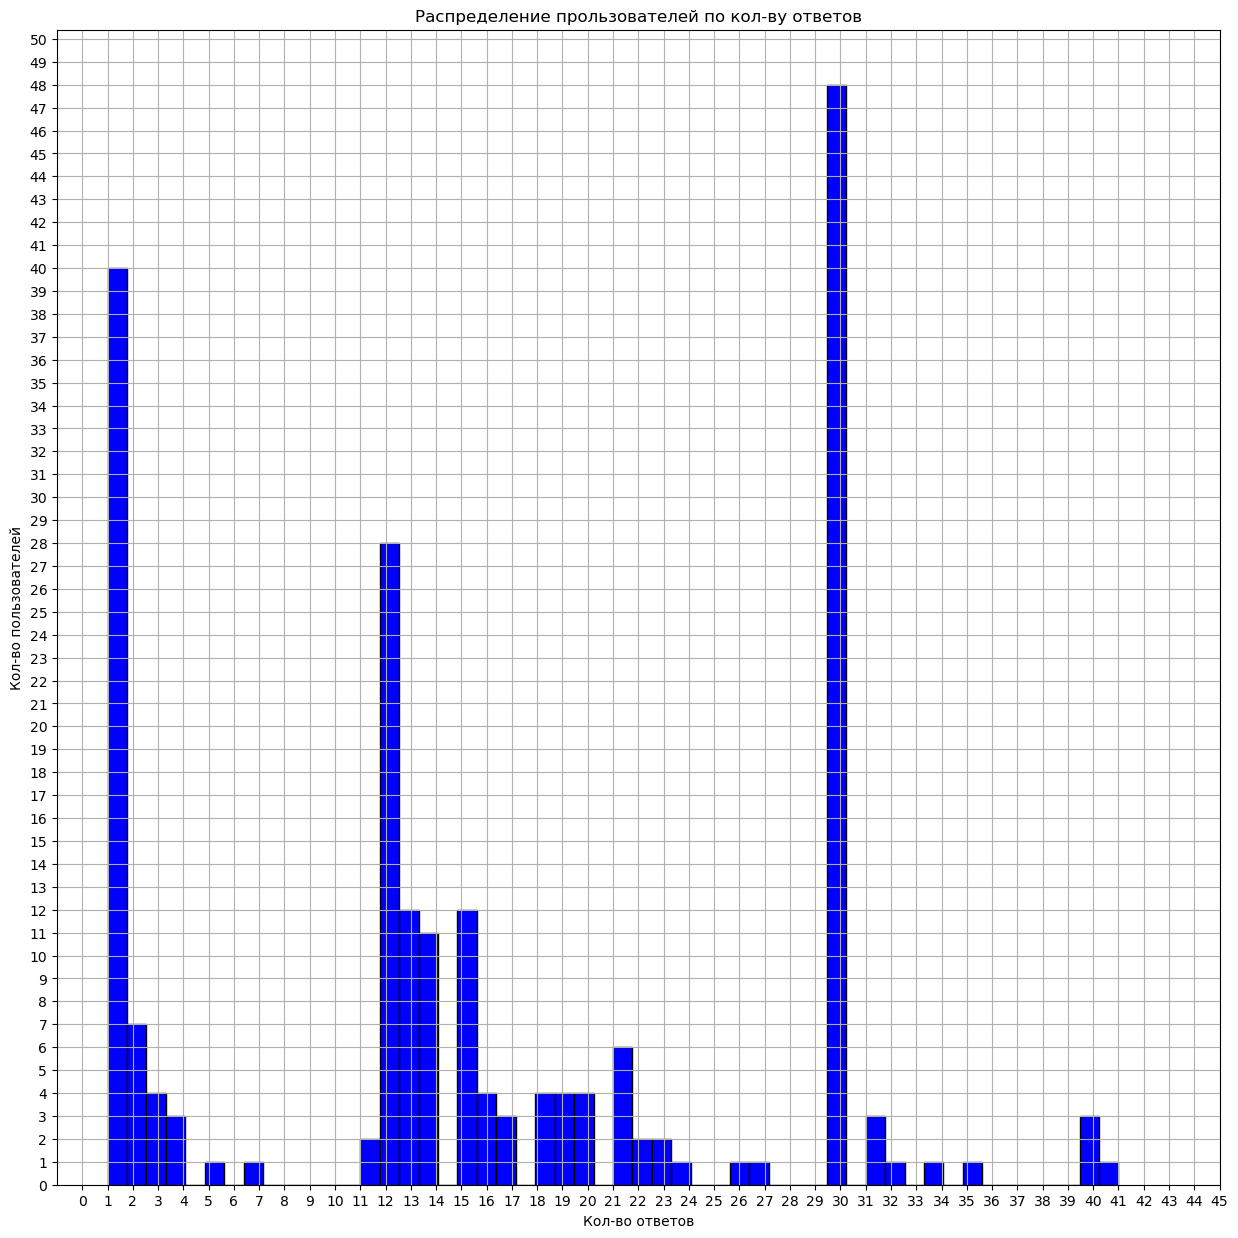

In [155]:
users_without_wrongs_value_counts_df = users_without_wrongs_value_counts.to_frame().reset_index()

min_ = users_without_wrongs_value_counts_df['count'].min()
max_ = users_without_wrongs_value_counts_df['count'].max()
# matplotlib histogram
plt.figure(figsize=(15,15))
plt.grid()
plt.hist(users_without_wrongs_value_counts_df['count'], color = 'blue', edgecolor = 'black', bins = int(users_without_wrongs_value_counts_df.user_id.count()/4))
plt.title('Распределение прользователей по кол-ву ответов')
plt.xlabel('Кол-во ответов')
plt.ylabel('Кол-во пользователей')
plt.xticks(np.arange(min_-1, max_+5, 1.0))
plt.yticks(np.arange(min_-1, max_+10, 1.0))
plt.show()

#### Все ответы ошибочные

In [152]:
# Все пользователи, у которых нет правильных ответов
users_with_wrongs = train_questions[~train_questions.user_id.isin(users_id_with_correct)]
users_with_wrongs.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62248,62248,0,1360462,5336,0,0,1,0,NaN,<NA>
62249,62249,17738,1360462,3553,0,1,1,0,19000.0,False
62250,62250,42543,1360462,88,0,2,2,0,9000.0,False
62251,62251,61111,1360462,4934,0,3,3,0,21000.0,False
62252,62252,87337,1360462,5609,0,4,1,0,9000.0,False
62253,62253,100838,1360462,3715,0,5,3,0,17000.0,False
62254,62254,123186,1360462,1002,0,6,0,0,11000.0,False
965193,965193,0,19887248,6368,0,0,3,0,NaN,<NA>
1528514,1528514,0,32305524,5078,0,0,2,0,NaN,<NA>
1528515,1528515,36035,32305524,4637,0,1,0,0,27000.0,False


In [153]:
''' Кол-во пользователей только с ошибочными ответами '''
users_with_wrongs.user_id.nunique()

186

In [154]:
''' Распределение пользователей по кол-ву нерешенных задач '''
users_with_wrongs_value_counts = users_with_wrongs.user_id.value_counts()
users_with_wrongs_value_counts

user_id
1260301701    33
553442376     30
839792187     30
569021000     21
857552040     19
              ..
1346773005     1
346289863      1
708495251      1
719804730      1
470439521      1
Name: count, Length: 186, dtype: int64

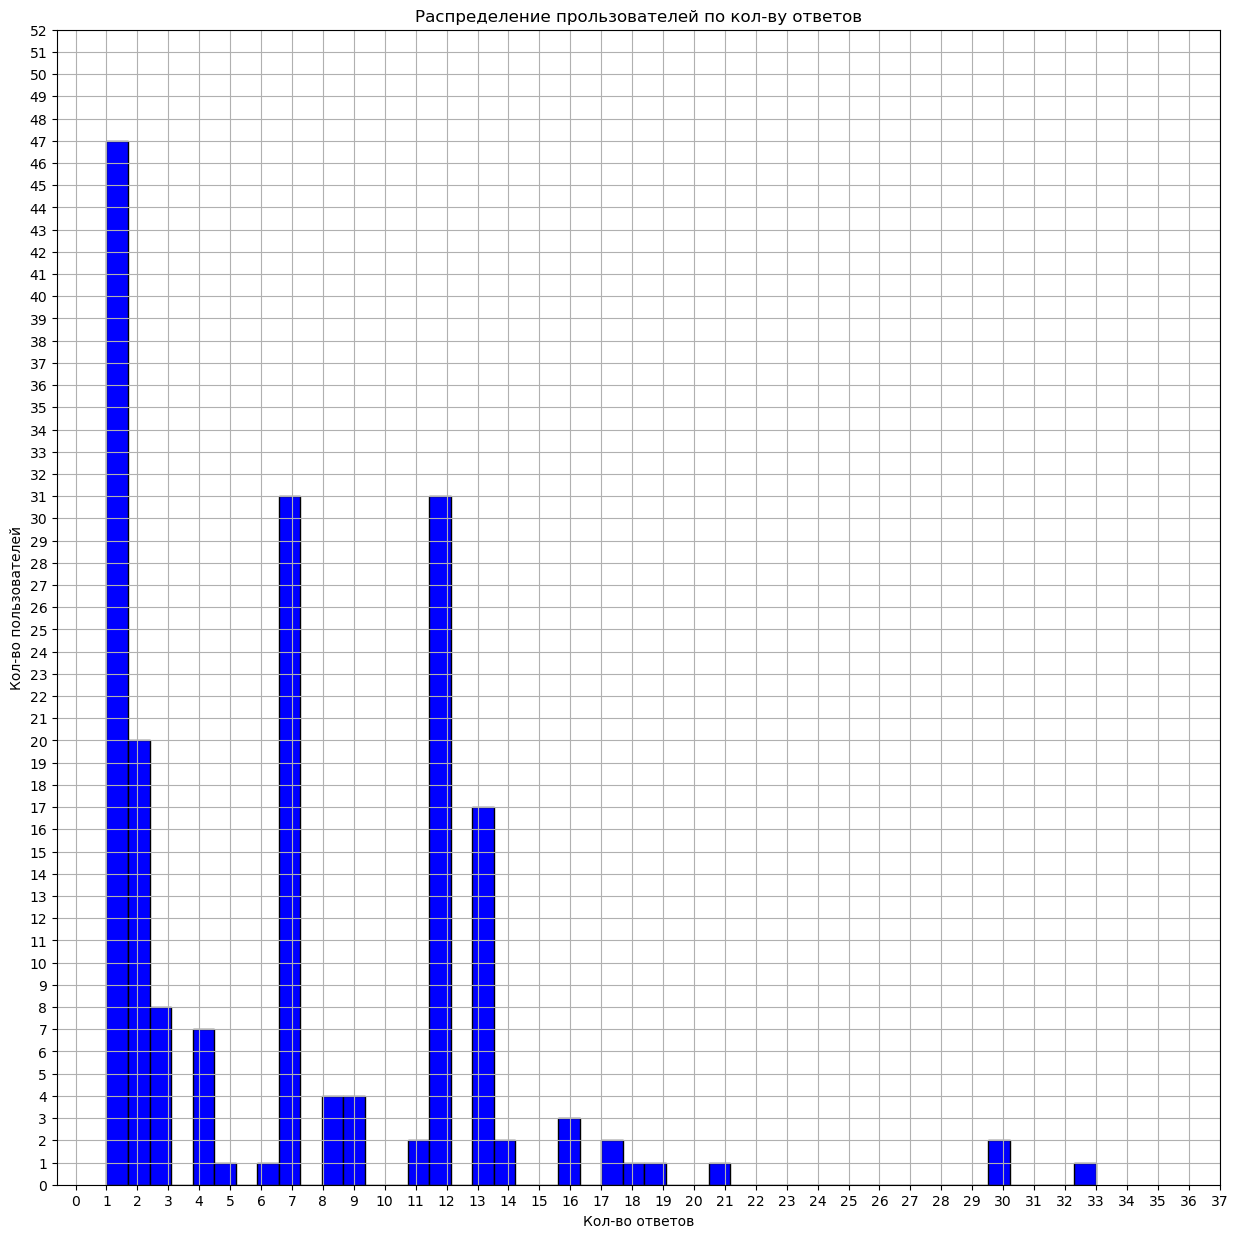

In [158]:
users_with_wrongs_value_counts_df = users_with_wrongs_value_counts.to_frame().reset_index()

min_ = users_with_wrongs_value_counts_df['count'].min()
max_ = users_with_wrongs_value_counts_df['count'].max()
# matplotlib histogram
plt.figure(figsize=(15,15))
plt.grid()
plt.hist(users_with_wrongs_value_counts_df['count'], color = 'blue', edgecolor = 'black', bins = int(users_with_wrongs_value_counts_df.user_id.count()/4))
plt.title('Распределение прользователей по кол-ву ответов')
plt.xlabel('Кол-во ответов')
plt.ylabel('Кол-во пользователей')
plt.xticks(np.arange(min_-1, max_+5, 1.0))
plt.yticks(np.arange(min_-1, max_+20, 1.0))
plt.show()